<h1 style="background-color:#4E9A06; color:#ffffff; padding:10px 15px; border-radius:5px; margin-top:1rem; margin-bottom:1rem; text-align:center;">
  02b – Interactive EDA for stakeholders
</h1>

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Objectives
</h2>
<ul>
  <li><strong>Provide non-technical stakeholders</strong> with intuitive, interactive visualizations of key findings from our climate-disease dataset.</li>
  <li><strong>Highlight</strong> spatial, temporal, and anomaly-driven disease risks in wild vs. agricultural systems.</li>
  <li><strong>Enable exploration</strong> of model insights (e.g. feature importances) without code.</li>
</ul>

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Inputs
</h2>
<ul>
  <li><strong>Cleaned dataset</strong>: <code>data/processed/merged_climate_disease_final.csv</code> (ETL-processed, anomalies computed, incidence zones assigned).</li>
  <li><strong>Model outputs</strong>: Pre-computed feature importances and OLS interaction summaries for Hypotheses 1–5.</li>
  <li><strong>Geographic metadata</strong>: Latitude/longitude, system type (Ag vs. Wild), pathogen group.</li>
</ul>

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Outputs
</h2>
<ul>
  <li><strong>Interactive world map</strong> showing survey locations colored by temperature and shaped by system type.</li>
  <li><strong>Anomaly vs. incidence plots</strong> (temperature &amp; precipitation) with LOWESS smoothing, colored by system, pathogen group, and transmission mode.</li>
  <li><strong>Stacked bar charts</strong> of pathogen distributions and host orders.</li>
  <li><strong>Feature importance dashboard</strong> (bar chart or table) to reveal top predictors from our ML models.</li>
</ul>

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Additional Comments
</h2>
<ul>
  <li>All visuals are implemented with Plotly/Streamlit for seamless interactivity.</li>
  <li>Designed for non-technical audiences: tooltips, legends, and clear titles.</li>
  <li>Future enhancements: geographic filtering sliders, time-series animations, exportable snapshots.</li>
</ul>
<hr>


<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
  2.0 Environment Setup & Imports
</h2>

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import numpy as np
import os
import plotly.io as pio
from IPython.display import Image, display
import statsmodels.api as sm
import plotly.graph_objects as go
import warnings

# silence just this pandas FutureWarning about observed=False
warnings.filterwarnings(
    "ignore",
    message="The default of observed=False is deprecated and will be changed to True.*",
    category=FutureWarning,
)
    
import plotly.express as px

# Add style_loader path manually
STYLE_DIR = Path.cwd() / "notebook_style"
if str(STYLE_DIR) not in sys.path:
    sys.path.insert(0, str(STYLE_DIR))

from style_loader import load_style

load_style()
print("Style loaded successfully")

# Fallback safety
WILD_COLOR = globals().get("WILD_COLOR", "#66c2a5")
AG_COLOR = globals().get("AG_COLOR", "#3288bd")


Injected custom CSS from: c:\Users\baner\OneDrive\Documenti\data_analytics_AI\capstone_CI_main\climacrop_health\climacrop_health\jupyter_notebooks\notebook_style\custom.css
Style loaded successfully


In [ ]:
import sys, os

# compute the absolute path to scripts/
notebooks_dir = os.getcwd()             # e.g. /path/to/project_root/jupyter_notebooks
scripts_dir   = os.path.abspath(os.path.join(notebooks_dir, "..", "scripts"))
sys.path.insert(0, scripts_dir)



<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 2: Section Header (H2) “2.1 Imports & Load Data”                     -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  2.1 Load Data
</h2>


In [6]:
# Load cleaned dataset from previous step
PROCESSED_DIR = Path("../data/processed")
cleaned_fp = PROCESSED_DIR / "merged_climate_disease_final.csv"

df = pd.read_csv(cleaned_fp)
print("Shape:", df.shape)
df.head()

Shape: (4932, 56)


study_id First_author  Study_Year Person_extracting Date_extracted  \
0      715       Abbate        2014            Vianda     2021-06-30   
1      715       Abbate        2014            Vianda     2021-06-30   
2      715       Abbate        2014            Vianda     2021-06-30   
3      715       Abbate        2014            Vianda     2021-06-30   
4      715       Abbate        2014            Vianda     2021-06-30   

  Paper_double_checked study_reference     Host.species      Host_family  \
0                Devin     Abbate_2014  Silene vulgaris  Caryophyllaceae   
1                Devin     Abbate_2014  Silene vulgaris  Caryophyllaceae   
2                Devin     Abbate_2014  Silene vulgaris  Caryophyllaceae   
3                Devin     Abbate_2014  Silene vulgaris  Caryophyllaceae   
4                Devin     Abbate_2014  Silene vulgaris  Caryophyllaceae   

       Host_order  ...  start_date monthly_temp contemp_temp contemp_precip  \
0  Caryophyllales  ...  2008-08-01   181.284576   288.956314       0.005280   
1  Caryophyllales  ...  2008-08-01   133.753340   288.499283       0.005288   
2  Caryophyllales  ...  2008-08-01   129.520853   288.499283       0.005288   
3  Caryophyllales  ...  2008-08-01   112.943493   288.128423       0.005225   
4  Caryophyllales  ...  2008-08-01   189.015197   288.499283       0.005288   

                                                .geo calculated_incidence  \
0  {"type":"Polygon","coordinates":[[[6.028999805...             0.000000   
1  {"type":"Polygon","coordinates":[[[6.117000102...             0.000000   
2  {"type":"Polygon","coordinates":[[[6.122000217...             0.000000   
3  {"type":"Polygon","coordinates":[[[6.147999763...             0.027778   
4  {"type":"Polygon","coordinates":[[[6.083000183...             0.000000   

  duration_mo temp_anomaly rain_anomaly incidence_zone  
0           1   107.671738   -78.742580            Low  
1           1   154.745943   -96.430852            Low  
2           1   158.978430   -98.153206            Low  
3           1   175.184930  -106.300282            Low  
4           1    99.484086   -77.163348            Low  

[5 rows x 56 columns]

In [7]:
df.columns.tolist()

['study_id',
 'First_author',
 'Study_Year',
 'Person_extracting',
 'Date_extracted',
 'Paper_double_checked',
 'study_reference',
 'Host.species',
 'Host_family',
 'Host_order',
 'Host_type',
 'Habitat',
 'Parasite_or_pest',
 'Antagonist_species',
 'Antagonist_type_specific',
 'Antagonist_type_general',
 'Detection_method',
 'Transmission_mode',
 'Vector_type',
 'Vector_species',
 'Latitude',
 'Longitude',
 'Coordinates_provided_in_study',
 'location',
 'system_type',
 'Sample_type',
 'Same_plants_tested_multiple',
 'Time_point',
 'Months',
 'Year',
 'Start Date (yyyymm)',
 'Span (months)',
 'Number_sampled_locations',
 'Coarse_spatial_scale',
 'Approx_spatial_accuracy_width_km',
 'Response metric',
 'n_plants',
 'n_infected',
 'incidence',
 'obs',
 'system:index',
 'Location',
 'annual_mean_temp',
 'annual_precip',
 'end_date',
 'monthly_precip',
 'start_date',
 'monthly_temp',
 'contemp_temp',
 'contemp_precip',
 '.geo',
 'calculated_incidence',
 'duration_mo',
 'temp_anomaly',
 'ra

In [8]:
# Recompute the needed columns:

# (a) Convert the survey (contemporaneous) temperature from K → °C
df["contemp_temp_C"] = df["contemp_temp"] - 273.15

# (b) Convert WorldClim “monthly_temp” (tenths of °C) → °C
df["monthly_temp_C"] = df["monthly_temp"] / 10.0

# (c) Convert WorldClim “annual_mean_temp” (tenths of °C) → °C
df["annual_mean_temp_C"] = df["annual_mean_temp"] / 10.0

# ────────────────────────────────────────────────────────────────────────────────
# 2) Compute the true Celsius‐based temperature anomaly:
# ────────────────────────────────────────────────────────────────────────────────

df["temp_anomaly_C"] = df["contemp_temp_C"] - df["monthly_temp_C"]

# ────────────────────────────────────────────────────────────────────────────────
# 3) Re‐compute rainfall anomalies (if not already correct):
#
#   - contemp_precip is already mm/day
#   - monthly_precip and annual_precip are in mm/month → convert to mm/day by dividing by 30
# ────────────────────────────────────────────────────────────────────────────────

# 1) Convert everything to mm/day
df["contemp_precip_mm_day"] = df["contemp_precip"] * 1000  # m d⁻¹ → mm d⁻¹
df["monthly_precip_mm_day"] = df["monthly_precip"] / 30.0  # mm month⁻¹ → mm d⁻¹
df["annual_precip_mm_day"] = df["annual_precip"] / 365.0  # mm yr⁻¹   → mm d⁻¹

# 2) Compute the anomaly in mm/day
df["rain_anomaly_mm_day"] = df["contemp_precip_mm_day"] - df["monthly_precip_mm_day"]

# 2) Absolute temperature anomaly
df["abs_temp_anom"] = (df["monthly_temp_C"] - df["contemp_temp_C"]).abs()

# 3) Absolute precipitation anomaly
#    raw monthly_precip is in mm/day already
df["abs_precip_anom"] = (df["monthly_precip_mm_day"] - df["contemp_precip"]).abs()

# 4) Standardize latitude/longitude column names
#    (ensure capitals if your plotting code expects 'Latitude','Longitude')
df.rename(columns={"latitude": "Latitude", "longitude": "Longitude"}, inplace=True)

# Verify
needed = ["contemp_temp_C", "abs_temp_anom", "abs_precip_anom", "Latitude", "Longitude"]
print("New columns present:", all(col in df.columns for col in needed))
df.head()

New columns present: True


study_id First_author  Study_Year Person_extracting Date_extracted  \
0      715       Abbate        2014            Vianda     2021-06-30   
1      715       Abbate        2014            Vianda     2021-06-30   
2      715       Abbate        2014            Vianda     2021-06-30   
3      715       Abbate        2014            Vianda     2021-06-30   
4      715       Abbate        2014            Vianda     2021-06-30   

  Paper_double_checked study_reference     Host.species      Host_family  \
0                Devin     Abbate_2014  Silene vulgaris  Caryophyllaceae   
1                Devin     Abbate_2014  Silene vulgaris  Caryophyllaceae   
2                Devin     Abbate_2014  Silene vulgaris  Caryophyllaceae   
3                Devin     Abbate_2014  Silene vulgaris  Caryophyllaceae   
4                Devin     Abbate_2014  Silene vulgaris  Caryophyllaceae   

       Host_order  ... contemp_temp_C monthly_temp_C annual_mean_temp_C  \
0  Caryophyllales  ...      15.806314      18.128458           9.585332   
1  Caryophyllales  ...      15.349283      13.375334           5.089478   
2  Caryophyllales  ...      15.349283      12.952085           4.695169   
3  Caryophyllales  ...      14.978423      11.294349           3.042547   
4  Caryophyllales  ...      15.349283      18.901520          10.294348   

  temp_anomaly_C contemp_precip_mm_day monthly_precip_mm_day  \
0      -2.322144              5.280471              2.624929   
1       1.973949              5.288383              3.214538   
2       2.397197              5.288383              3.271950   
3       3.684074              5.224704              3.543517   
4      -3.552237              5.288383              2.572288   

  annual_precip_mm_day rain_anomaly_mm_day abs_temp_anom abs_precip_anom  
0             2.584914            2.655542      2.322144        2.619648  
1             3.515521            2.073845      1.973949        3.209250  
2             3.609112            2.016433      2.397197        3.266661  
3             3.995283            1.681187      3.684074        3.538292  
4             2.461131            2.716095      3.552237        2.567000  

[5 rows x 66 columns]

We will plot visualizations that might be interesting for our stakeholders:

- Technical teams
- Farmers
- Environmental agency

## 1. Mapping the Landscape (Global Map of Survey Sites)
Goal: Display the geographic spread of surveys, with markers shaped by system type (Agricultural vs. Wild) and colored by average temperature.

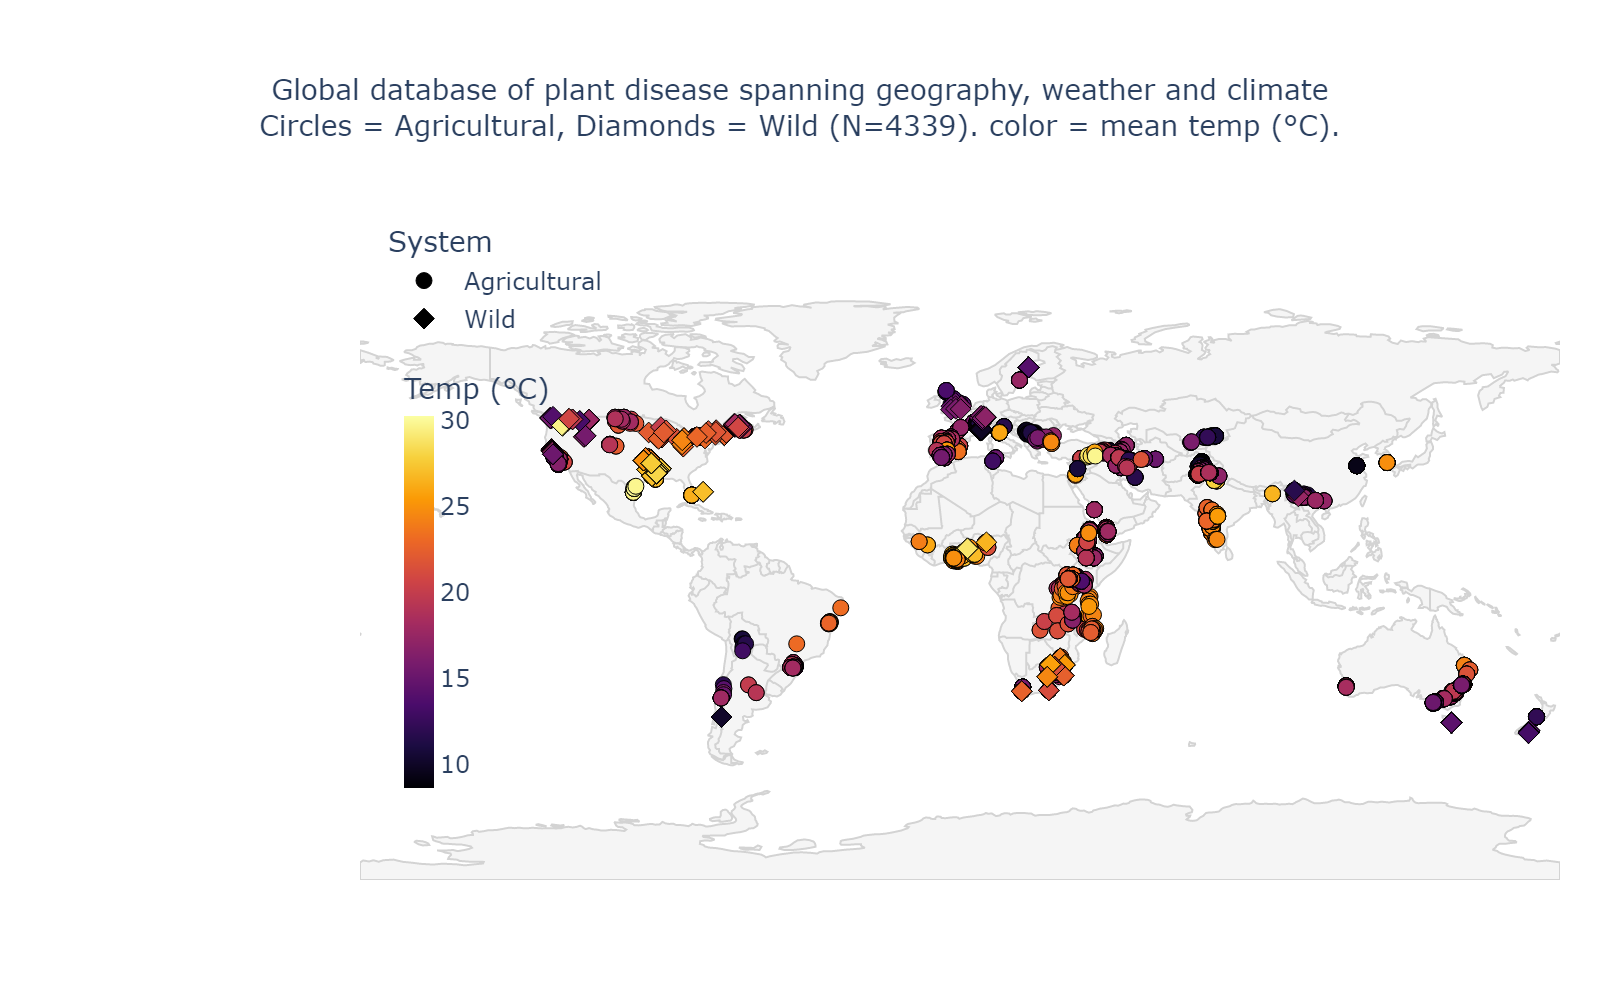

Saved high-res PNG to images/global_map.png


In [9]:
import plotly.graph_objects as go
import plotly.io as pio

# 1) Make sure you have the System column
df["System"] = df["system_type"].map({"Ag": "Agricultural", "Natural": "Wild"})


fig_map = go.Figure()

# Add one trace per system
for system, symbol in [("Agricultural", "circle"), ("Wild", "diamond")]:
    df_sub = df[df["System"] == system]
    fig_map.add_trace(
        go.Scattergeo(
            lon=df_sub["Longitude"],
            lat=df_sub["Latitude"],
            mode="markers",
            name=system,
            marker=dict(
                symbol=symbol,
                size=8,
                line=dict(width=0.5, color="black"),
                color=df_sub["contemp_temp_C"],
                coloraxis="coloraxis",
                colorscale="Inferno",
                colorbar=dict(
                    title="Temp (°C)",
                    tickformat=".0f",
                    x=-0.12,  # left of map
                    y=0.5,
                    yanchor="middle",
                    len=0.6,
                    thickness=15,
                    outlinecolor="black",
                ),
            ),
            hovertemplate=(
                "<b>%{text}</b><br><br>"
                "Temp: %{marker.color:.1f} °C<br>"
                "Incidence: %{customdata[0]:.2f}<br>"
                "Year: %{customdata[1]}<br>"
                "Agent: %{customdata[2]}<br>"
                "Host order: %{customdata[3]}<extra></extra>"
            ),
            text=df_sub["System"],
            customdata=df_sub[
                ["calculated_incidence", "Study_Year", "Parasite_or_pest", "Host_order"]
            ].values,
        )
    )

# 2) Configure the shared coloraxis (single bar)
fig_map.update_layout(
    coloraxis=dict(
        colorscale="Inferno",
        colorbar=dict(
            title="Temp (°C)",
            tickformat=".0f",
            x=0.02,  # move colorbar to left margin
            y=0.5,
            yanchor="middle",
            len=0.6,
            thickness=15,
            outlinecolor="black",
        ),
    )
)
# 3) Update layout & projection
fig_map.update_geos(
    visible=False,
    showcountries=True,
    countrycolor="lightgray",
    showland=True,
    landcolor="whitesmoke",
)
fig_map.update_layout(
    legend=dict(
        title="System",
        x=0.02,  # far left
        y=0.98,  # top
        xanchor="left",
        yanchor="top",
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=12),
    ),
    title=(
        "Global database of plant disease spanning geography, weather and climate<br>"
        "Circles = Agricultural, Diamonds = Wild (N=4339). color = mean temp (°C)."
    ),
    title_x=0.5,
    title_font_size=14,
    margin=dict(l=180, r=20, t=100, b=20),
    width=1000,
    height=600,
    template="plotly",
)


# 4) Show inline (Notebook mode)

pio.renderers.default = "notebook_connected"
fig_map.show()

# 1) Export interactive HTML to disk (optional)
fig_map.write_html("../images/global_map.html", include_plotlyjs="cdn")

# 2) Produce a static PNG in memory and display it immediately:
png_bytes = pio.to_image(fig_map, format="png", width=800, height=500, scale=2)
display(Image(png_bytes))

# 3) Export to high-res PNG at ~300 dpi
#    width_inches = width_pixels / dpi → here: 1000px / 300dpi ≈ 3.33"
#    so scale=3 gives 3000px → 300dpi at ~10" wide
fig_map.write_image(
    "../images/global_map.png", format="png", width=1000, height=600, scale=3
)
print("Saved high-res PNG to images/global_map.png")

Technical teams:

- Shows strong clustering in mid‐latitudes and Africa—consider potential spatial sampling bias.

- Color gradient confirms wide temperature coverage (10–30 °C), ideal for model generalization.

Farmer:

- See our region’s marker density—are we under‐ or over‐represented?

- Hover to compare local incidence rates and survey years.

Environmental Agency:

- Identify “cold‐spots” (few surveys) for targeted wild‐plant disease monitoring.

- Map guides resource allocation for new survey campaigns.

## 2.Climate Variable Correlations (Correlation Heatmap)
Goal: Show how different climate variables correlate with each other. Dark blue indicates strong positive correlation, while dark red shows strong negative correlation.

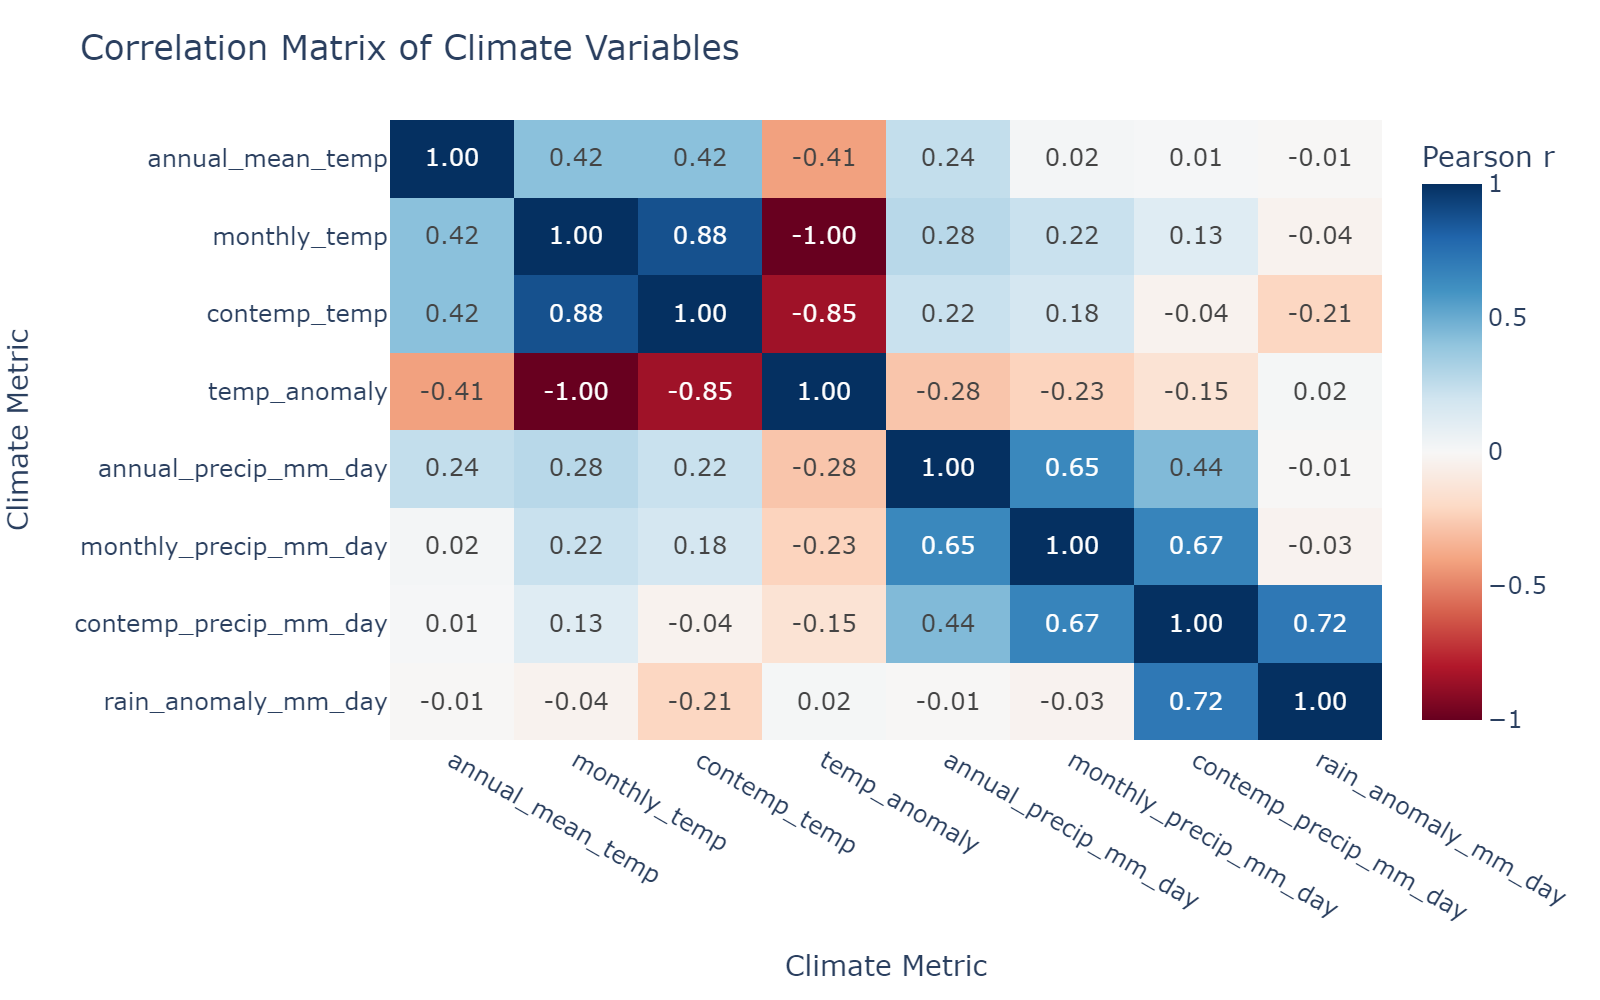

In [10]:
import plotly.express as px

climate_cols = [
    "annual_mean_temp",
    "monthly_temp",
    "contemp_temp",
    "temp_anomaly",
    "annual_precip_mm_day",
    "monthly_precip_mm_day",
    "contemp_precip_mm_day",
    "rain_anomaly_mm_day",
]

# 2) Compute correlation matrix
corr_matrix = df[climate_cols].corr()

# 2) Plot with a blue-white-red diverging scale
fig_corr = px.imshow(
    corr_matrix,
    labels=dict(x="Climate Metric", y="Climate Metric", color="Pearson r"),
    x=climate_cols,
    y=climate_cols,
    color_continuous_scale="RdBu",  # reversed Red-Blue: blue=+1, red=-1
    zmin=-1,
    zmax=1,
    text_auto=".2f",
    aspect="auto",
)
fig_corr.update_layout(
    title="Correlation Matrix of Climate Variables",
    width=700,
    height=700,
    template="plotly_white",
)
fig_corr.show()

# 1) Export interactive HTML to disk (optional)
fig_corr.write_html("../images/corr.html", include_plotlyjs="cdn")

# 2) Produce a static PNG in memory and display it immediately:
png_bytes = pio.to_image(fig_corr, format="png", width=800, height=500, scale=2)
display(Image(png_bytes))


Technical team:

- Temperature metrics collapse into two clusters (historical vs. contemporary); anomalies are orthogonal—use them for feature selection.

- Rain anomaly is wholly independent of historical normals—prime predictor for mismatch models.

Farmer:

- You only need to watch one rainfall measure (e.g. monthly) instead of juggling annual, monthly, and contemporary—simplify your weather alerts.

Environmental Agency:

- Focus on anomaly indices for early warning; reduce redundant sensor deployments for historical baselines.

## 3. Weather vs. Disease: The Mismatch Effect

Goal: Visualize how temperature anomalies correlate with disease incidence for both Agricultural and Wild systems.

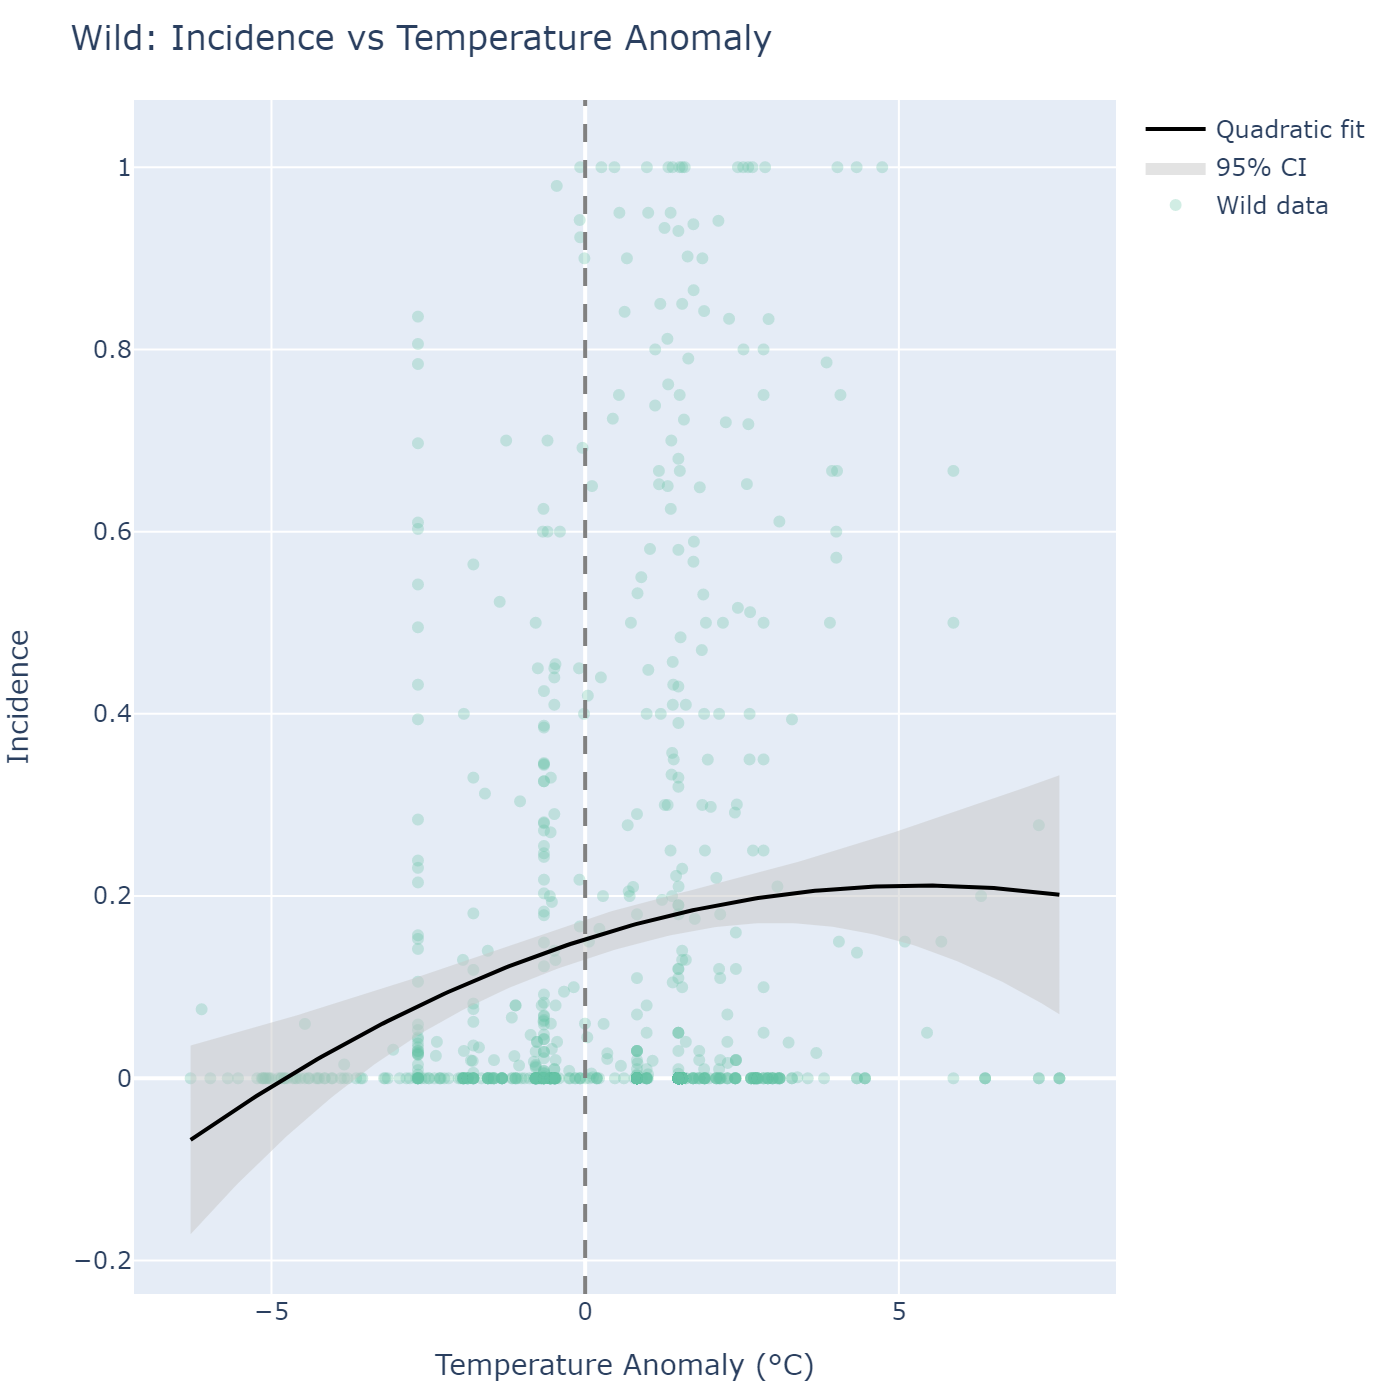

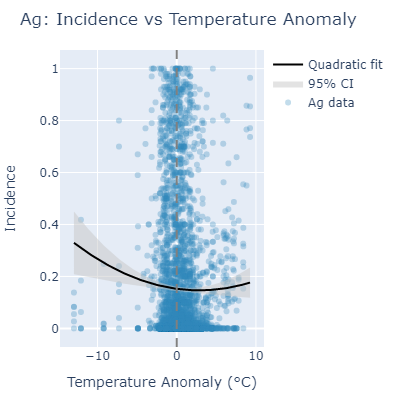

In [23]:
# helper
def fit_quadratic_and_ci(df_sub, xcol, ycol, x_min=None, x_max=None, npoints=200):
    X = pd.DataFrame(
        {"const": 1.0, "x1": df_sub[xcol].values, "x2": df_sub[xcol].values ** 2}
    )
    y = df_sub[ycol].values
    model = sm.OLS(y, X).fit()
    if x_min is None:
        x_min = df_sub[xcol].min()
    if x_max is None:
        x_max = df_sub[xcol].max()
    x_pred = np.linspace(x_min, x_max, npoints)
    Xp = pd.DataFrame({"const": 1.0, "x1": x_pred, "x2": x_pred**2})
    pf = model.get_prediction(Xp).summary_frame(alpha=0.05)
    return x_pred, pf["mean"], pf["mean_ci_lower"], pf["mean_ci_upper"]


# Split data
wild_df = df[df["system_type"] == "Natural"]
ag_df = df[df["system_type"] == "Ag"]

# === Panel (a): Wild ===
x_pred, yhat, lo, hi = fit_quadratic_and_ci(wild_df, "temp_anomaly_C", "incidence")

fig_wdtempinc = go.Figure(
    [
        # raw data
        go.Scatter(
            x=wild_df["temp_anomaly_C"],
            y=wild_df["incidence"],
            mode="markers",
            marker=dict(color=WILD_COLOR, opacity=0.3, size=6),
            name="Wild data",
        ),
        # upper CI line (invisible)
        go.Scatter(x=x_pred, y=hi, mode="lines", line=dict(width=0), showlegend=False),
        # lower CI + fill
        go.Scatter(
            x=x_pred,
            y=lo,
            mode="lines",
            fill="tonexty",
            fillcolor="rgba(200,200,200,0.5)",
            line=dict(width=0),
            name="95% CI",
        ),
        # quadratic fit
        go.Scatter(
            x=x_pred,
            y=yhat,
            mode="lines",
            line=dict(color="black", width=2),
            name="Quadratic fit",
        ),
    ]
)

# vertical line at x=0
fig_wdtempinc.update_layout(
    shapes=[
        dict(
            type="line",
            x0=0,
            x1=0,
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="gray", dash="dash"),
        )
    ],
    title="Wild: Incidence vs Temperature Anomaly",
    xaxis_title="Temperature Anomaly (°C)",
    yaxis_title="Incidence",
    width=600,
    height=500,
    margin=dict(l=60, r=20, t=50, b=50),
)

fig_wdtempinc.show()

# 4) (Optional) Export to interactive HTML
fig_wdtempinc.write_html("../images/Wd_tempinc.html", include_plotlyjs="cdn")

# 5) (Optional) Display static PNG inline
png_bytes = pio.to_image(fig_wdtempinc, format="png", width=700, height=700, scale=2)
display(Image(png_bytes))


# === Panel (d): Ag ===
x_pred, yhat, lo, hi = fit_quadratic_and_ci(ag_df, "temp_anomaly_C", "incidence")

fig_agtempinc = go.Figure(
    [
        go.Scatter(
            x=ag_df["temp_anomaly_C"],
            y=ag_df["incidence"],
            mode="markers",
            marker=dict(color=AG_COLOR, opacity=0.3, size=6),
            name="Ag data",
        ),
        go.Scatter(x=x_pred, y=hi, mode="lines", line=dict(width=0), showlegend=False),
        go.Scatter(
            x=x_pred,
            y=lo,
            mode="lines",
            fill="tonexty",
            fillcolor="rgba(200,200,200,0.5)",
            line=dict(width=0),
            name="95% CI",
        ),
        go.Scatter(
            x=x_pred,
            y=yhat,
            mode="lines",
            line=dict(color="black", width=2),
            name="Quadratic fit",
        ),
    ]
)

fig_agtempinc.update_layout(
    shapes=[
        dict(
            type="line",
            x0=0,
            x1=0,
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="gray", dash="dash"),
        )
    ],
    title="Ag: Incidence vs Temperature Anomaly",
    xaxis_title="Temperature Anomaly (°C)",
    yaxis_title="Incidence",
    width=600,
    height=500,
    margin=dict(l=60, r=20, t=50, b=50),
)

fig_agtempinc.show()


# 4) (Optional) Export to interactive HTML
fig_agtempinc.write_html("../images/Ag_tempinc.html", include_plotlyjs="cdn")

# 5) (Optional) Display static PNG inline
png_bytes = pio.to_image(fig_agtempinc, format="png", width=400, height=400, scale=1)
display(Image(png_bytes))


Technical team:

- Wild systems show a U‐shaped response (negative quadratic), confirming the significant negative anomaly × historical interaction.

- Agricultural curve is near‐linear, validating the buffering effect.

Farmer:

- When your field’s temperature strays ±2 °C from the norm, watch for spikes in wild‐host disease—but crops are safer until extremes.

Environmental Agency:

- Use anomaly thresholds to trigger alerts in protected areas with wild flora—you’ll catch outbreaks at their onset.

Goal: Visualize how rainfall anomalies correlate with disease incidence for both Agricultural and Wild systems.

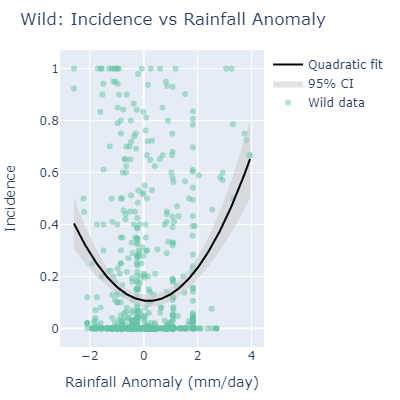

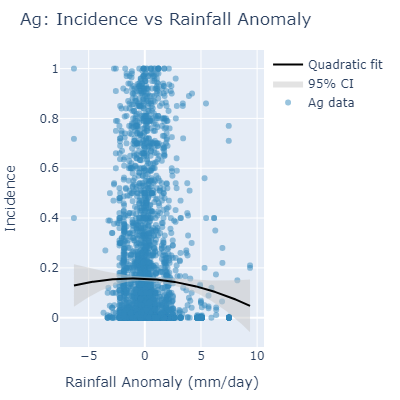

In [12]:
# helper
def fit_quadratic_and_ci(df_sub, xcol, ycol, x_min=None, x_max=None, npoints=200):
    X = pd.DataFrame(
        {"const": 1.0, "x1": df_sub[xcol].values, "x2": df_sub[xcol].values ** 2}
    )
    y = df_sub[ycol].values
    model = sm.OLS(y, X).fit()
    if x_min is None:
        x_min = df_sub[xcol].min()
    if x_max is None:
        x_max = df_sub[xcol].max()
    x_pred = np.linspace(x_min, x_max, npoints)
    Xp = pd.DataFrame({"const": 1.0, "x1": x_pred, "x2": x_pred**2})
    pf = model.get_prediction(Xp).summary_frame(alpha=0.05)
    return x_pred, pf["mean"], pf["mean_ci_lower"], pf["mean_ci_upper"]


# Split data
wild_df = df[df["system_type"] == "Natural"]
ag_df = df[df["system_type"] == "Ag"]

# === Panel (a): Wild ===
x_pred, yhat, lo, hi = fit_quadratic_and_ci(wild_df, "rain_anomaly_mm_day", "incidence")

fig_wrain = go.Figure(
    [
        # Scatter
        go.Scatter(
            x=wild_df["rain_anomaly_mm_day"],
            y=wild_df["incidence"],
            mode="markers",
            marker=dict(color=WILD_COLOR, opacity=0.5, size=6),
            name="Wild data",
        ),
        # CI upper (invisible line)
        go.Scatter(x=x_pred, y=hi, mode="lines", line=dict(width=0), showlegend=False),
        # CI lower + fill
        go.Scatter(
            x=x_pred,
            y=lo,
            mode="lines",
            fill="tonexty",
            fillcolor="rgba(200,200,200,0.5)",
            line=dict(width=0),
            name="95% CI",
        ),
        # Fit line
        go.Scatter(
            x=x_pred,
            y=yhat,
            mode="lines",
            line=dict(color="black", width=2),
            name="Quadratic fit",
        ),
    ]
)

fig_wrain.update_layout(
    title="Wild: Incidence vs Rainfall Anomaly",
    xaxis_title="Rainfall Anomaly (mm/day)",
    yaxis_title="Incidence",
    width=600,
    height=500,
    margin=dict(l=60, r=20, t=50, b=50),
)

fig_wrain.show()

# 4) (Optional) Export to interactive HTML
fig_wrain.write_html("../images/Wd_raininc.html", include_plotlyjs="cdn")

# 5) (Optional) Display static PNG inline
png_bytes = pio.to_image(fig_wrain, format="png", width=400, height=400, scale=1)
display(Image(png_bytes))

# === Panel (d): Ag ===
x_pred, yhat, lo, hi = fit_quadratic_and_ci(ag_df, "rain_anomaly_mm_day", "incidence")

fig_agrain = go.Figure(
    [
        go.Scatter(
            x=ag_df["rain_anomaly_mm_day"],
            y=ag_df["incidence"],
            mode="markers",
            marker=dict(color=AG_COLOR, opacity=0.5, size=6),
            name="Ag data",
        ),
        go.Scatter(x=x_pred, y=hi, mode="lines", line=dict(width=0), showlegend=False),
        go.Scatter(
            x=x_pred,
            y=lo,
            mode="lines",
            fill="tonexty",
            fillcolor="rgba(200,200,200,0.5)",
            line=dict(width=0),
            name="95% CI",
        ),
        go.Scatter(
            x=x_pred,
            y=yhat,
            mode="lines",
            line=dict(color="black", width=2),
            name="Quadratic fit",
        ),
    ]
)

fig_agrain.update_layout(
    title="Ag: Incidence vs Rainfall Anomaly",
    xaxis_title="Rainfall Anomaly (mm/day)",
    yaxis_title="Incidence",
    width=600,
    height=500,
    margin=dict(l=60, r=20, t=50, b=50),
)

fig_agrain.show()

# 4) (Optional) Export to interactive HTML
fig_agrain.write_html("../images/Ag_raininc.html", include_plotlyjs="cdn")

# 5) (Optional) Display static PNG inline
png_bytes = pio.to_image(fig_agrain, format="png", width=400, height=400, scale=1)
display(Image(png_bytes))


## 4. Pathogen & Host Distributions

Goal: Show the distribution of pathogens and host orders in Agricultural vs. Wild systems.

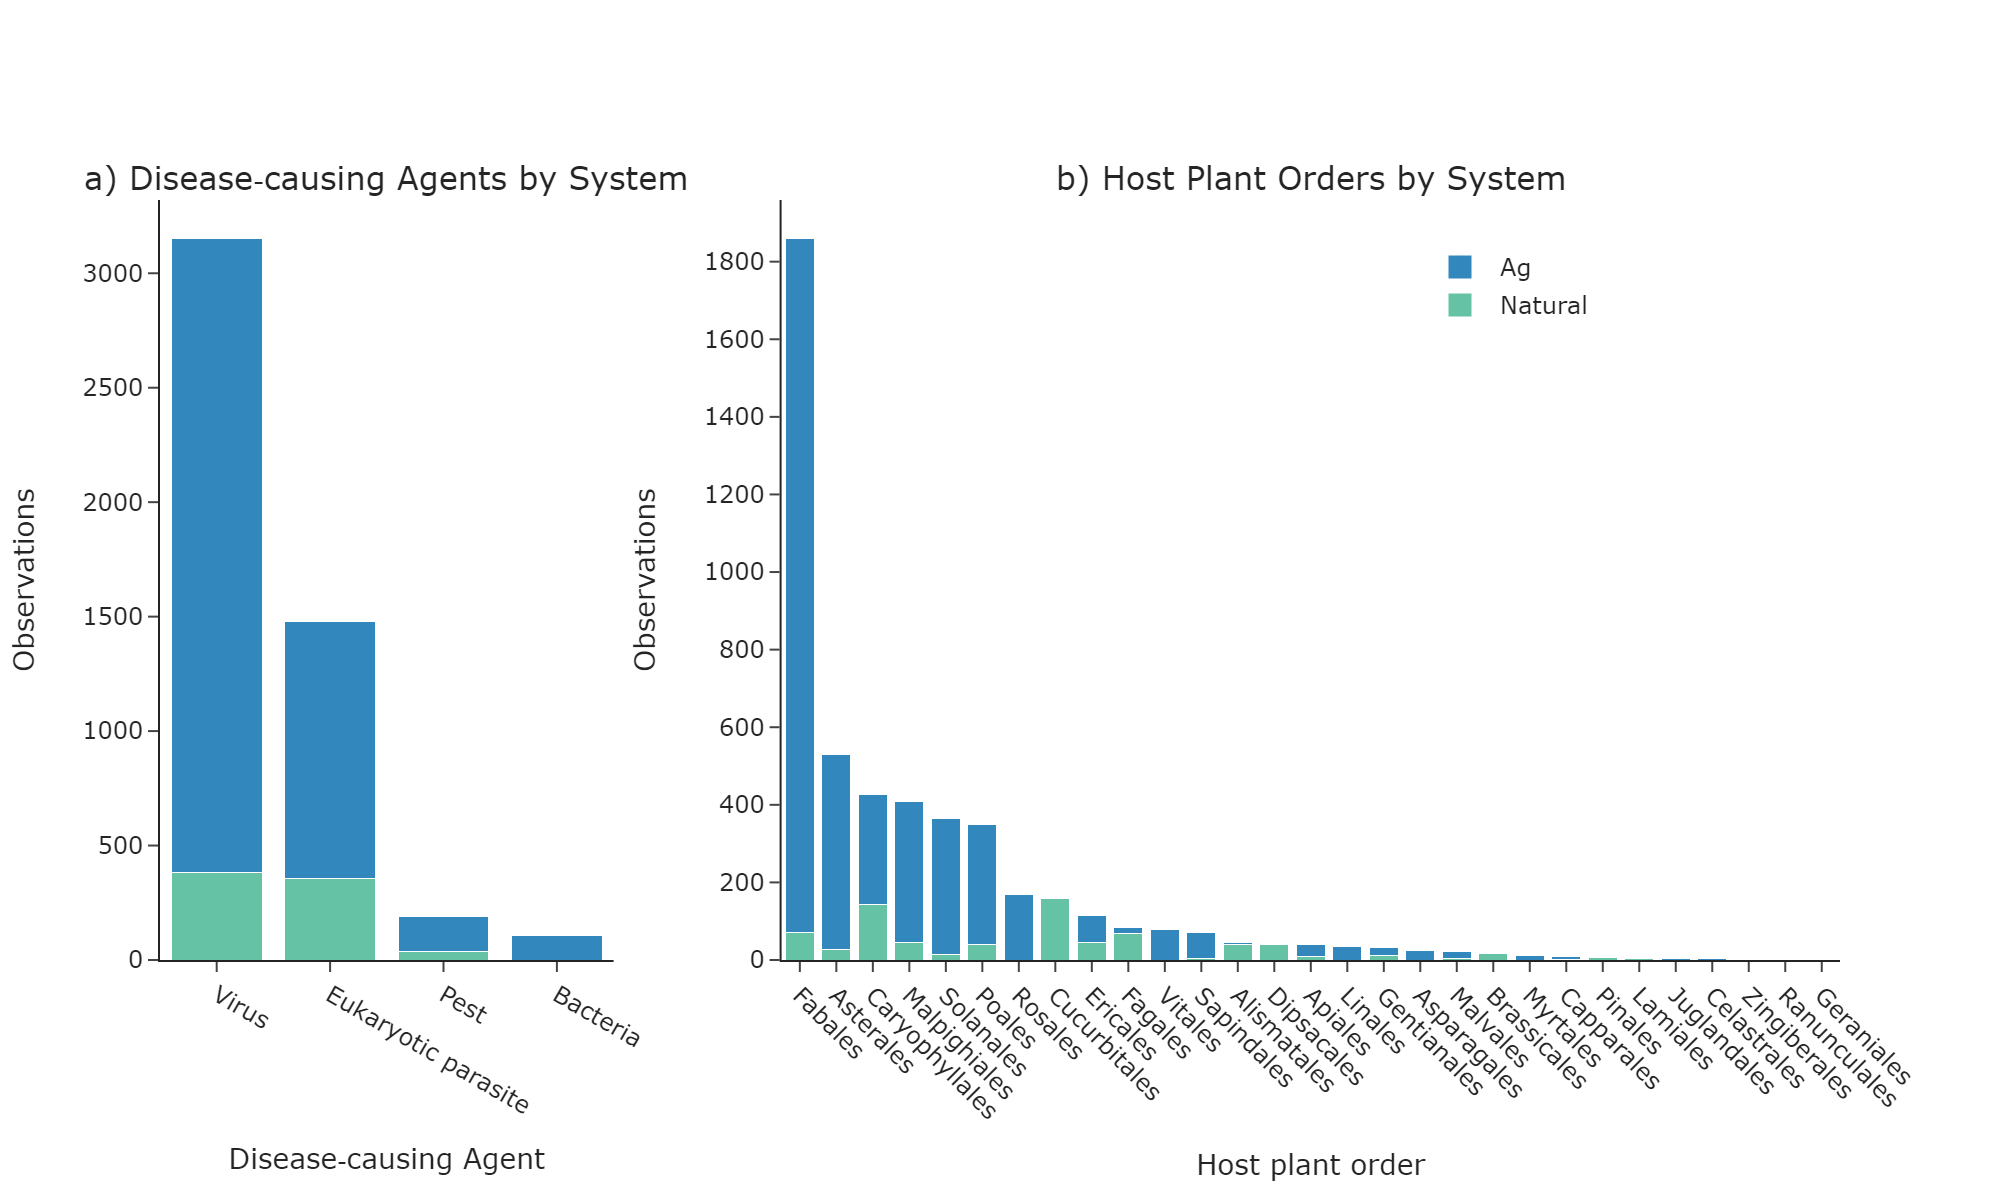

Wrote ../images/Pathogen_host_dist.html


In [25]:
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import display, Image

# Pull in your brand colours
ag_color   = globals().get("AG_COLOR", "#1565C0")
wd_color   = globals().get("WILD_COLOR","#2E7D32")

# 1) Prepare counts
agent_counts = (
    df.groupby(["Antagonist_type_general", "system_type"], observed=True)
      .size().unstack(fill_value=0)
      .loc[["Virus", "Eukaryotic parasite", "Pest", "Bacteria"]]
)

host_counts = (
    df[df["Host_order"] != "Unknown"]
      .groupby(["Host_order", "system_type"])
      .size().unstack(fill_value=0)
)
host_counts["total"] = host_counts.sum(axis=1)
host_counts = host_counts.sort_values("total", ascending=False).drop(columns="total")

# 2) Build 1×2 subplot
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        "a) Disease‐causing Agents by System",
        "b) Host Plant Orders by System",
    ),
    column_widths=[0.3, 0.7],
)

# Left: show legend
for sys, color in zip(["Natural", "Ag"], [wd_color, ag_color]):
    fig.add_trace(
        go.Bar(
            x=agent_counts.index,
            y=agent_counts[sys],
            name=sys,
            marker_color=color,
            showlegend=True
        ),
        row=1, col=1,
    )
fig.update_xaxes(title_text="Disease‐causing Agent", row=1, col=1)
fig.update_yaxes(title_text="Observations",           row=1, col=1)

# Right: suppress legend
for sys, color in zip(["Natural", "Ag"], [wd_color, ag_color]):
    fig.add_trace(
        go.Bar(
            x=host_counts.index,
            y=host_counts[sys],
            name=sys,
            marker_color=color,
            showlegend=False
        ),
        row=1, col=2,
    )
fig.update_xaxes(
    title_text="Host plant order",
    row=1, col=2,
    tickangle=45
)
fig.update_yaxes(title_text="Observations", row=1, col=2)

# 3) Final layout
fig.update_layout(
    barmode="stack",
    template="simple_white",
    height=600,
    width=1000,
    legend=dict(x=0.75, y=0.95),
)

# 4) Show inline static PNG (optional)
png_bytes = pio.to_image(fig, format="png", width=1000, height=600, scale=2)
display(Image(png_bytes))

# 5) Save interactive HTML
os.makedirs("../images", exist_ok=True)
out_path = "../images/Pathogen_host_dist.html"
fig.write_html(out_path, include_plotlyjs="cdn")
print(f"Wrote {out_path}")


Technical team:

- Viruses and eukaryotic parasites dominate agricultural surveys; bacterial and pest data are sparse—balance your modeling samples.

Farmer:

- In your crops, prioritize virus and fungal parasite diagnostics—over 80 % of surveys report these.

Environmental Agency:

- Wild surveys include more “Pinales” and “Vitales” hosts—tailor your wild‐plant protection to these orders.

## 5. Who Lives in What Climate? (Climate Distributions by Pathogen & System)

Goal: Compare the climatic distributions for each pathogen group in Agricultural vs. Wild settings.

**Temperature**

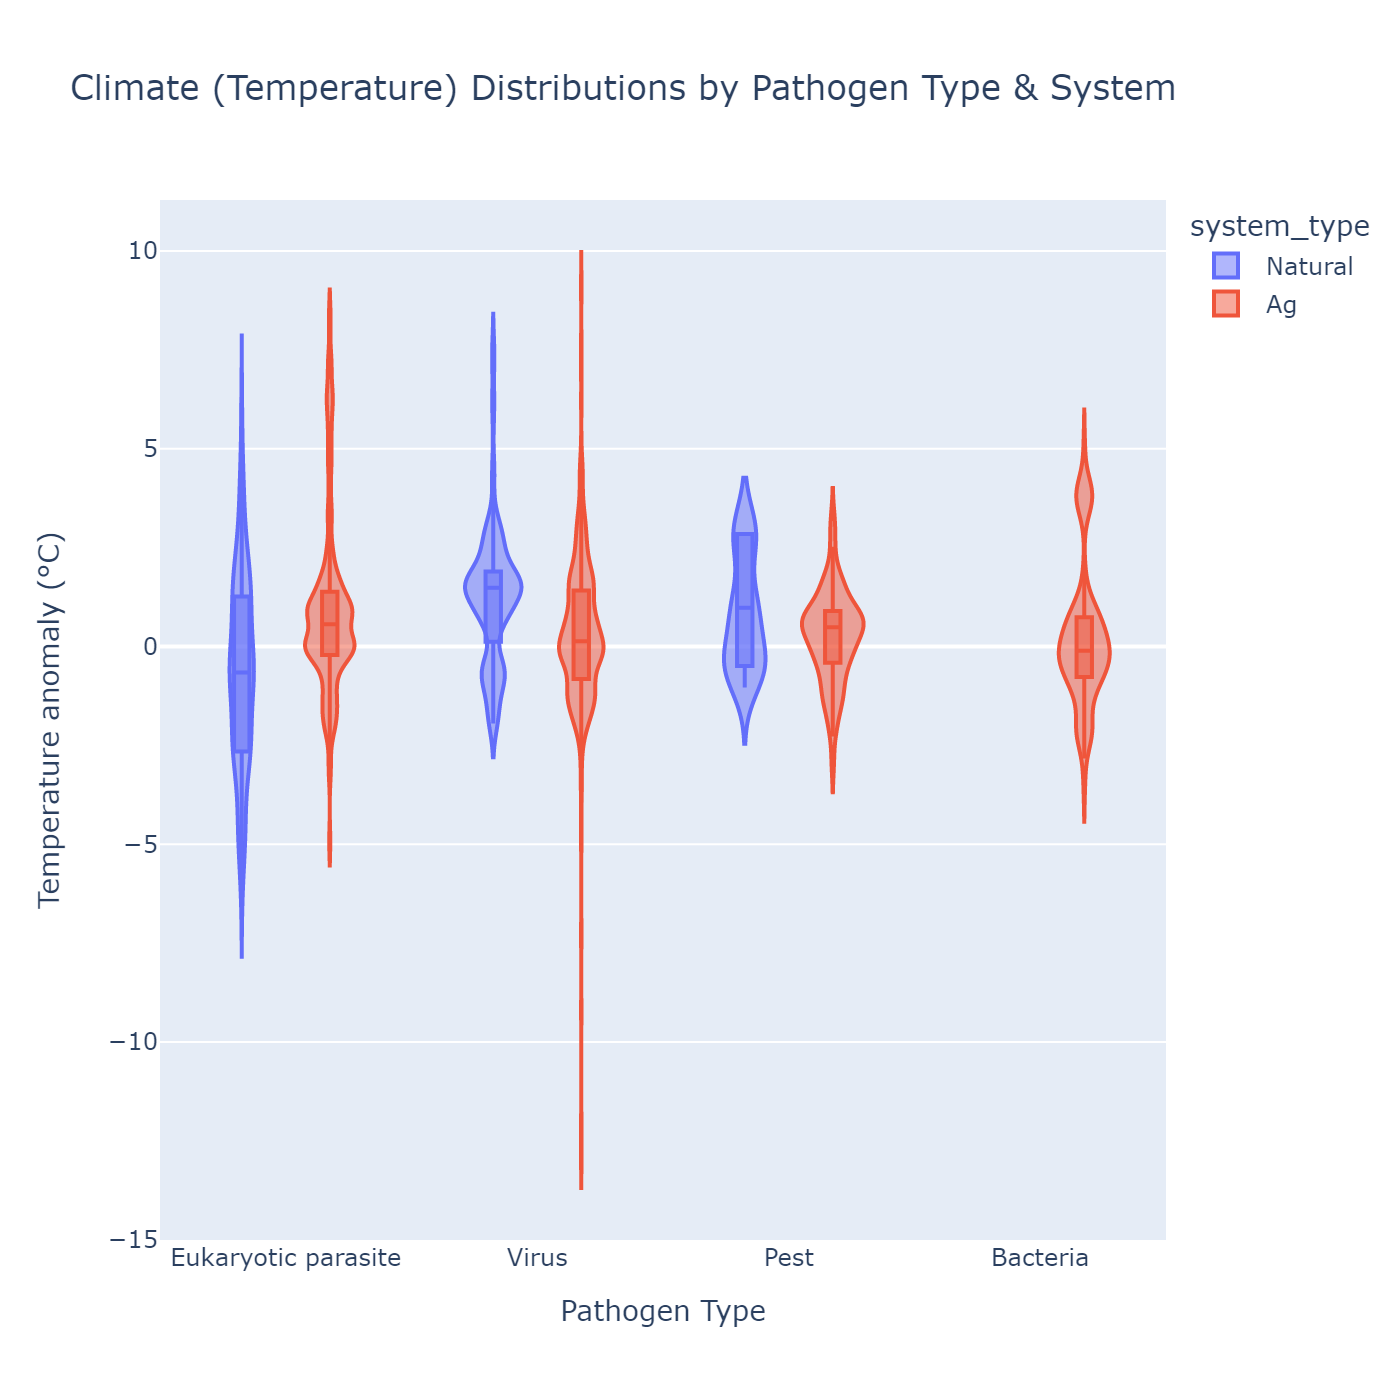

In [21]:
import plotly.express as px

fig_violin_temp_pathost = px.violin(
    df,
    y="temp_anomaly_C",
    x="Antagonist_type_general",
    color="system_type",
    box=True,
    points=False,
    hover_data=["Parasite_or_pest", "Host_order"],
    title="Climate (Temperature) Distributions by Pathogen Type & System",
)

fig_violin_temp_pathost.update_layout(
    yaxis_title="Temperature anomaly (°C)", xaxis_title="Pathogen Type", template="plotly"
)

fig_violin_temp_pathost.show()

# 4) (Optional) Export to interactive HTML
fig_violin_temp_pathost.write_html("../images/Violin_Temp_pathost.html", include_plotlyjs="cdn")

png_bytes = pio.to_image(fig_violin_temp_pathost, format="png", width=700, height=700, scale=2)
display(Image(png_bytes))


**Precipitation**

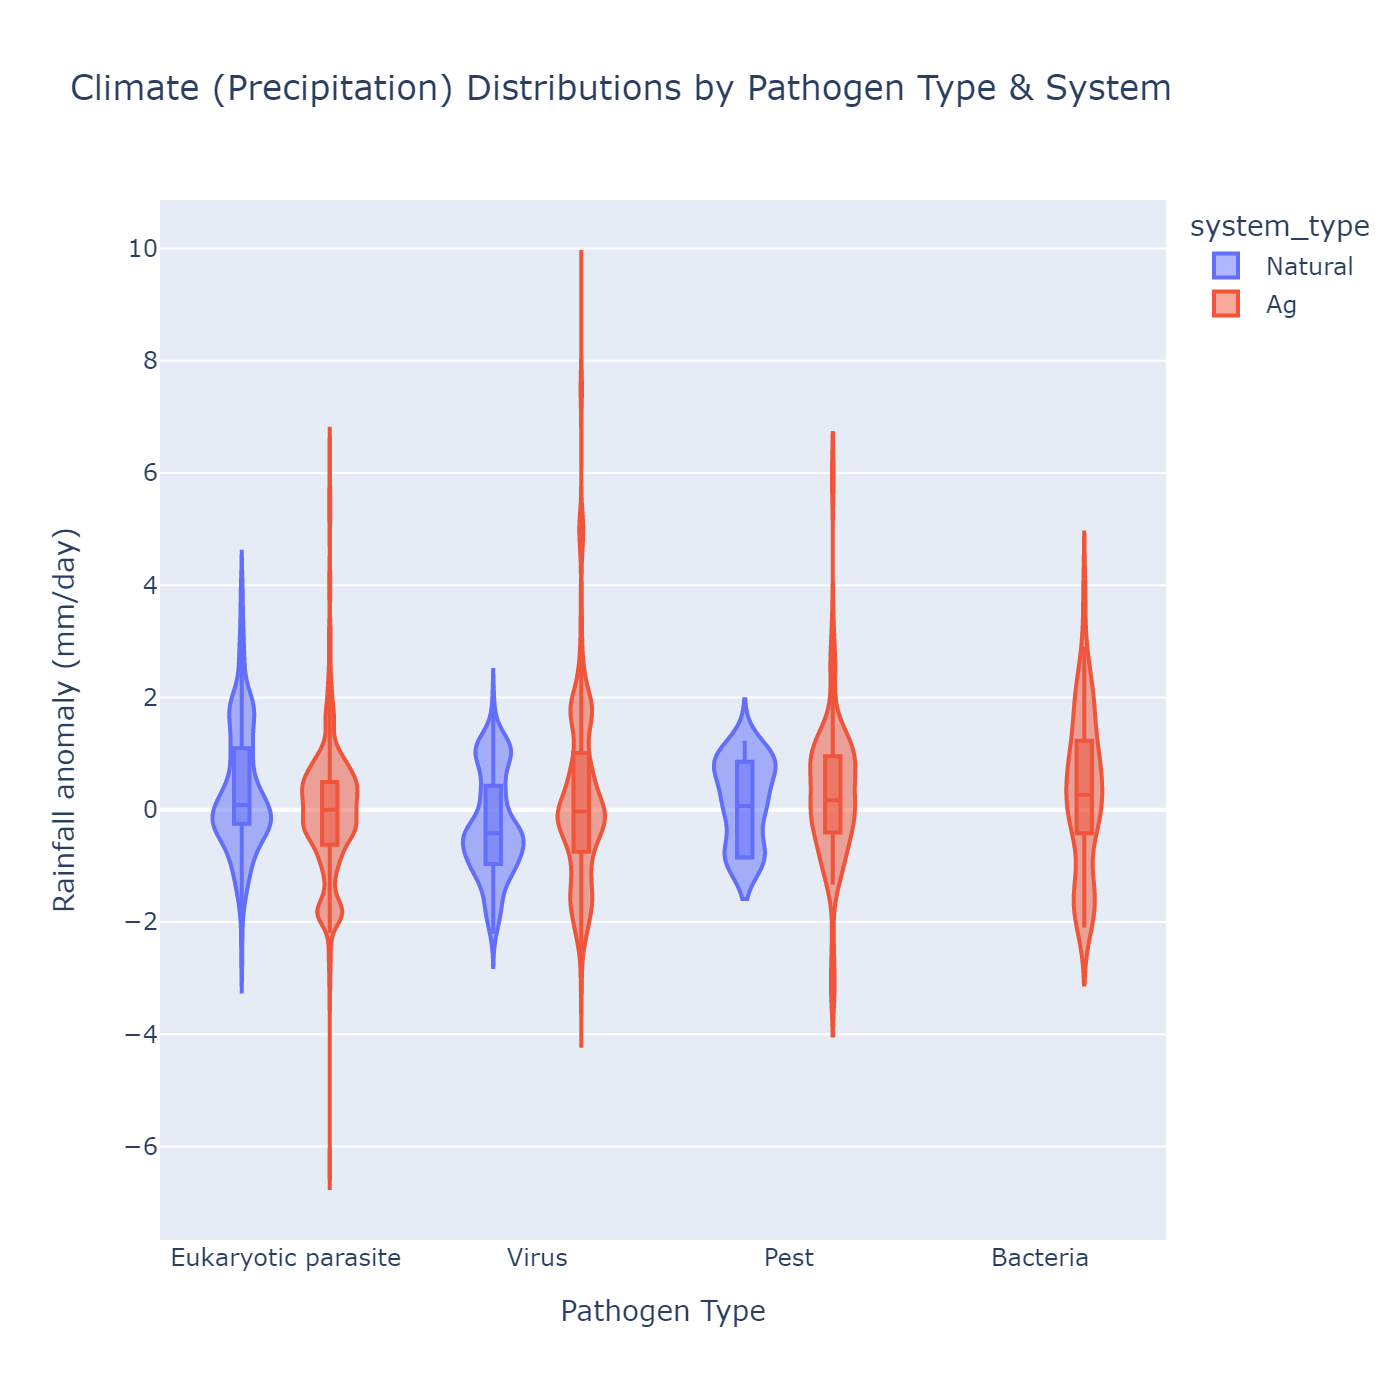

In [20]:
fig_violin_rain_pathost = px.violin(
    df,
    y="rain_anomaly_mm_day",
    x="Antagonist_type_general",
    color="system_type",
    box=True,
    points=False,
    hover_data=["Parasite_or_pest", "Host_order"],
    title="Climate (Precipitation) Distributions by Pathogen Type & System",
)

fig_violin_rain_pathost.update_layout(
    yaxis_title="Rainfall anomaly (mm/day)", xaxis_title="Pathogen Type", template="plotly"
)

fig_violin_rain_pathost.show()


# 4) (Optional) Export to interactive HTML
fig_violin_rain_pathost.write_html("../images/Violin_Rain_pathost.html", include_plotlyjs="cdn")

png_bytes = pio.to_image(fig_violin_rain_pathost, format="png", width=700, height=700, scale=2)
display(Image(png_bytes))

- Technical Team:

Violin shapes show that pests occupy cooler and wetter niches in wild systems, while viruses span warmer, drier extremes in crops—cluster your model residuals by group.

- Farmer:

If you grow legumes (Fabales) under ~20–25 °C, expect more virus incidence; plan your planting window accordingly.

- Environmental Agency:

Wild pathogens see rainfall anomalies up to –4 mm/day; focus surveillance in regions forecast for deep drought.

In [16]:
temp_metrics = [
    "annual_mean_temp_C",
    "monthly_temp_C",
    "contemp_temp_C",
    "temp_anomaly_C",
]
label_map = {
    "annual_mean_temp_C":    "Historical annual average temperature (°C)",
    "monthly_temp_C":        "Historical monthly average temperature (°C)",
    "contemp_temp_C":        "Contemporary average temperature (°C)",
    "temp_anomaly_C":        "Temperature anomaly (°C)",
}


In [17]:
# 1) Melt
melt = df.melt(
    id_vars=["System", "Antagonist_type_general"],
    value_vars=temp_metrics,
    var_name="Metric",
    value_name="Value",
)
melt["Metric Label"] = melt["Metric"].map(label_map)

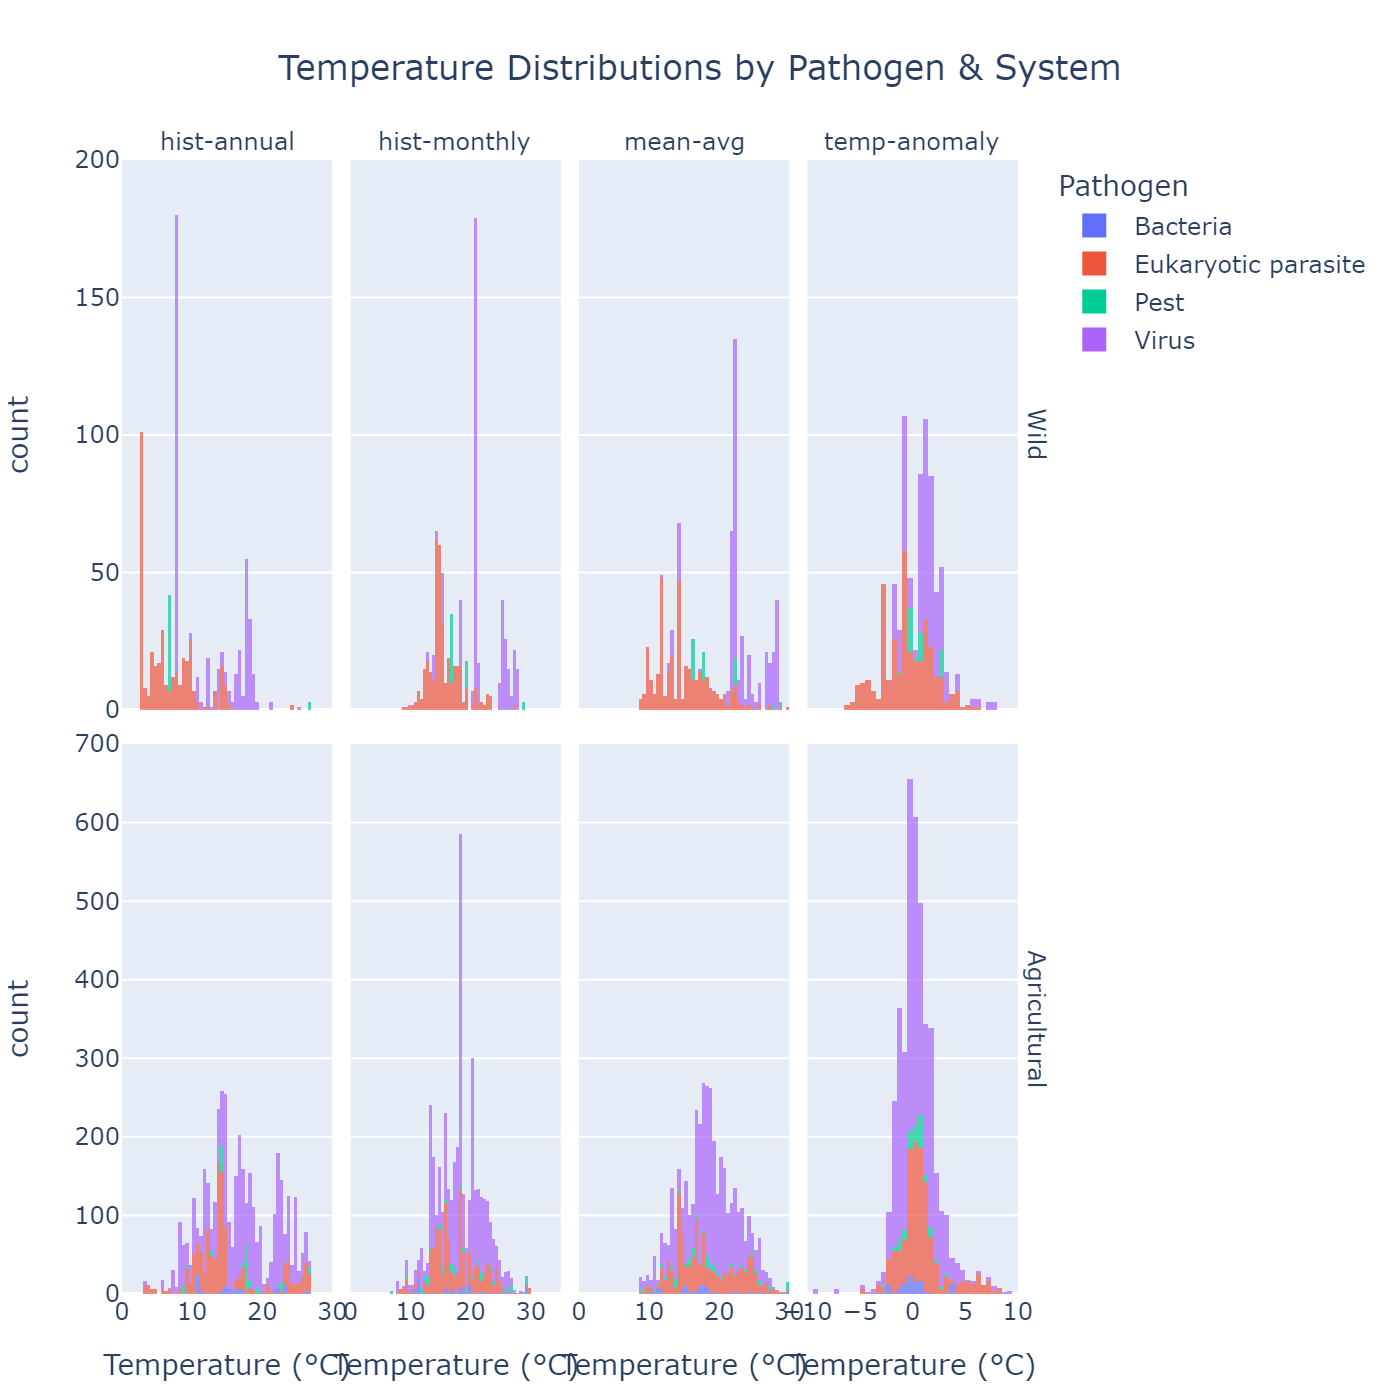

In [18]:
# 2) Short titles + ordering
short_map = {
    label_map["annual_mean_temp_C"]:  "hist-annual",
    label_map["monthly_temp_C"]:      "hist-monthly",
    label_map["contemp_temp_C"]:      "mean-avg",
    label_map["temp_anomaly_C"]:      "temp-anomaly",
}
melt["Metric Short"] = melt["Metric Label"].map(short_map)
ordered_short = [short_map[label_map[m]] for m in temp_metrics]
melt["Metric Short"] = pd.Categorical(
    melt["Metric Short"],
    categories=ordered_short,
    ordered=True
)

# 3) Build the faceted histogram
fig_temp_path = px.histogram(
    melt,
    x="Value",
    color="Antagonist_type_general",
    facet_row="System",
    facet_col="Metric Short",
    barmode="stack",
    opacity=0.7,
    category_orders={
        "System": ["Wild", "Agricultural"],
        "Metric Short": ordered_short,
        "Antagonist_type_general": sorted(melt["Antagonist_type_general"].unique()),
    },
    labels={
        "Value": "Temperature (°C)",
        "Antagonist_type_general": "Pathogen",
    },
    title="Temperature Distributions by Pathogen & System",
    height=600,
    width=1200,
)

# 4) Tidy titles & margins
fig_temp_path.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig_temp_path.update_layout(
    legend_title_text="Pathogen",
    title_x=0.5,
    margin=dict(t=80, b=40, l=40, r=40),
)
fig_temp_path.update_xaxes(matches=None); fig_temp_path.update_yaxes(matches=None)
fig_temp_path.update_yaxes(range=[0,700], row=1); fig_temp_path.update_yaxes(range=[0,200], row=2)
fig_temp_path.update_xaxes(range=[0,30], col=1); fig_temp_path.update_xaxes(range=[0,35], col=2)
fig_temp_path.update_xaxes(range=[0,30], col=3); fig_temp_path.update_xaxes(range=[-10,10], col=4)
# ─────────────────────────────────────────────────────

# write to HTML
fig_temp_path.write_html("../images/temp_pathogen_distributions.html", include_plotlyjs="cdn")

png_bytes = pio.to_image(fig_temp_path, format="png", width=700, height=700, scale=2)
display(Image(png_bytes))

# 7) Render
fig_temp_path.show()


**Rainfall**

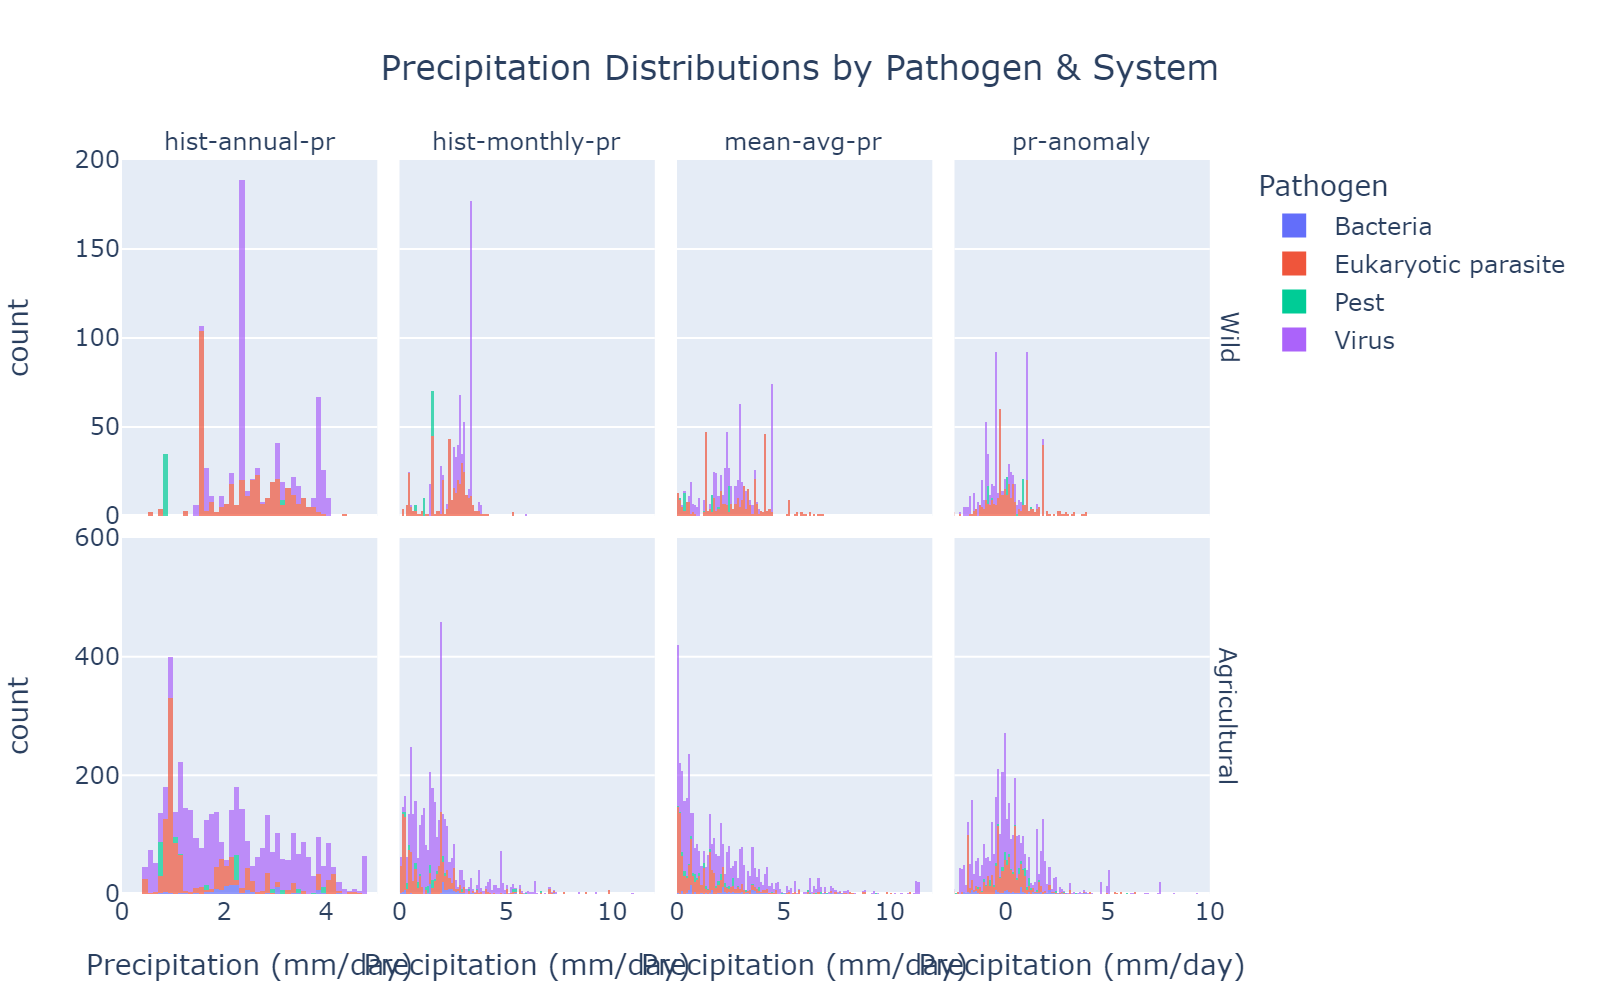

In [19]:
# ——————————————————————————————————————————————
# 0) (Re)define your precipitation metrics & labels
precip_metrics = [
    "annual_precip_mm_day",    # historical annual average daily precipitation
    "monthly_precip_mm_day",   # historical monthly average daily precipitation
    "contemp_precip_mm_day",   # contemporary average daily precipitation
    "rain_anomaly_mm_day",     # precipitation anomaly
]
precip_label_map = {
    "annual_precip_mm_day":  "Historical annual average daily precipitation (mm/day)",
    "monthly_precip_mm_day": "Historical monthly average daily precipitation (mm/day)",
    "contemp_precip_mm_day": "Contemporary average daily precipitation (mm/day)",
    "rain_anomaly_mm_day":   "Precipitation anomaly (mm/day)",
}

# ——————————————————————————————————————————————
# 1) Melt to long form
melt_pr = df.melt(
    id_vars=["System", "Antagonist_type_general"],
    value_vars=precip_metrics,
    var_name="Metric",
    value_name="Value",
)
melt_pr["Metric Label"] = melt_pr["Metric"].map(precip_label_map)

# ——————————————————————————————————————————————
# 2) Short titles + enforce ordering
short_map_pr = {
    precip_label_map["annual_precip_mm_day"]:  "hist-annual-pr",
    precip_label_map["monthly_precip_mm_day"]: "hist-monthly-pr",
    precip_label_map["contemp_precip_mm_day"]: "mean-avg-pr",
    precip_label_map["rain_anomaly_mm_day"]:   "pr-anomaly",
}
melt_pr["Metric Short"] = melt_pr["Metric Label"].map(short_map_pr)
ordered_short_pr = [short_map_pr[precip_label_map[m]] for m in precip_metrics]
melt_pr["Metric Short"] = pd.Categorical(
    melt_pr["Metric Short"],
    categories=ordered_short_pr,
    ordered=True
)

# ——————————————————————————————————————————————
# 3) Build the Plotly Express histogram with facets
fig_pr = px.histogram(
    melt_pr,
    x="Value",
    color="Antagonist_type_general",
    facet_row="System",
    facet_col="Metric Short",
    barmode="stack",
    opacity=0.7,        
    category_orders={
        "System": ["Wild", "Agricultural"],
        "Metric Short": ordered_short_pr,
        "Antagonist_type_general": sorted(melt_pr["Antagonist_type_general"].unique()),
    },
    labels={
        "Value": "Precipitation (mm/day)",
        "Antagonist_type_general": "Pathogen",
    },
    title="Precipitation Distributions by Pathogen & System",
    height=600,
    width=1200,
)

# ——————————————————————————————————————————————
# 4) Clean up facet titles & margins
fig_pr.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig_pr.update_layout(
    legend_title_text="Pathogen",
    title_x=0.5,
    margin=dict(t=80, b=40, l=40, r=40),
)

# ——————————————————————————————————————————————
# 5) Un-link axes so we can set them individually
fig_pr.update_xaxes(matches=None)
fig_pr.update_yaxes(matches=None)

# 6) Clamp y-axes per row:
#    Wild (row=1) → 0–200
fig_pr.update_yaxes(range=[0, 200], row=2)
#    Agricultural (row=2) → 0–600
fig_pr.update_yaxes(range=[0, 600], row=1)

# 7) Clamp x-axes per metric column:
fig_pr.update_xaxes(range=[0, 5],   col=1)  # hist-annual-pr
fig_pr.update_xaxes(range=[0, 12],  col=2)  # hist-monthly-pr
fig_pr.update_xaxes(range=[0, 12],  col=3)  # mean-avg-pr
fig_pr.update_xaxes(range=[-2.5, 10], col=4) # pr-anomaly

# write to HTML
fig_pr.write_html("../images/precip_pathogen_distributions.html", include_plotlyjs="cdn")

# 2) Produce a static PNG in memory and display it immediately:
png_bytes = pio.to_image(fig_pr, format="png", width=800, height=500, scale=2)
display(Image(png_bytes))

# 8) Render
fig_pr.show()


- Technical Team:

Horizontal orientation makes heavy‐tailed distributions (e.g. anomalies) easier to read across bins.

Dropdown lets you spot skewness and outliers per metric interactively.

- Farmer:

Click “Temperature anomaly” to see how often your region has >2 °C deviations—plan irrigation or shade interventions.

- Environmental Agency:

Compare “Rainfall anomaly” vs. “Contemporary precipitation” distributions to decide which meteorological service to fund.

## 6. Model Feature Importances

Goal: Visualize the top predictors of disease risk based on your ML model.

- Technical team:

Temperature anomaly leads, followed by precipitation anomaly—confirms our OLS & RandomForest results.

Drop low‐importance covariates to simplify future models.

- Farmer:

Keep an eye on forecasts for both heatwaves and drought spells—you’ll get the highest ROI on prevention.

- Environmental Agency:

Invest in anomaly‐focused monitoring programs (e.g., satellite soil moisture, SPI) rather than static climatologies.



## 7. What’s Next?

For future enhancements:

- Time-slider animation: Watch how survey locations and temperatures change year-by-year.

- Seasonal Trends: Line charts of average incidence by calendar month.

- Sankey Flows: Visualize how incidence zones flow between Agricultural and Wild systems.

- Parallel Coordinates: Explore each survey’s multivariate fingerprint across climate, duration, and incidence.